# How do we plot a resistivity model from towed time-domain electromagnetic data?

Author: Seogi Kang (email: sgkang09@stanford.edu)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import path
path.append("../python_codes/")
import ttem 
from ttem import Stitched1DModel, plot_layer
from scipy.spatial import cKDTree as KDTree
import matplotlib
matplotlib.rcParams['font.size'] = 14

## Step 1: Load the AEM resistivity data

In [48]:
import io
def read_work_bench_xyz_mod(fname):
    with open(fname, 'r') as fid:
        lines = fid.readlines()
    n_header_max = 100
    for ii, line in enumerate(lines):
        if '/' in line:
            pass
        else:
            break

    header = lines[ii-1].split()[1:]
    n_columns = len(header)
    n_sounding = len(lines[ii:])
    data = np.zeros((n_sounding, n_columns))
    for jj, line in enumerate(lines[ii:]):
        data[jj,:] = np.array(line.split(), dtype=float)
    df = pd.DataFrame(data=data, columns=header)
    tmp_thk = np.array(header)[['THK' in header for header in header]]
    thk_names = tmp_thk[:int(len(tmp_thk)/2)]
    tmp_rho = np.array(header)[['RHO' in header for header in header]]
    rho_names = tmp_rho[:int(len(tmp_thk)/2)+1]
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    hz = np.unique(df[thk_names].values)
    hz = np.r_[hz, hz[-1]]
    resistivity= df[rho_names].values[:,:]
    line = df['LINE_NO'].values
    return df, topo, hz, resistivity, line

In [49]:
file_name = "../models/SCI_I01_MOD_inv.xyz"
df, topography, hz, resistivity, line = read_work_bench_xyz_mod(file_name)

In [50]:
topography[:,2]= 83.7

In [51]:
np.median(topography[:,2])

83.7

In [52]:
df.head(3)

,LINE_NO,UTMX,UTMY,TIMESTAMP,FID,RECORD,ELEVATION,ALT,INVALT,INVALTSTD,...,DEP_BOT_STD_12,DEP_BOT_STD_13,DEP_BOT_STD_14,DEP_BOT_STD_15,DEP_BOT_STD_16,DEP_BOT_STD_17,DEP_BOT_STD_18,DEP_BOT_STD_19,DOI_CONSERVATIVE,DOI_STANDARD
0,100.0,612797.5625,4115638.75,44696.850909,1.0,1.0,84.1,9999.0,9999.0,9999.0,...,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,41.419,50.581
1,100.0,612797.2500,4115638.50,44696.850911,2.0,2.0,84.1,9999.0,9999.0,9999.0,...,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,7.978,11.943
2,100.0,612794.8750,4115636.00,44696.850926,3.0,3.0,84.1,9999.0,9999.0,9999.0,...,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,41.073,50.627


In [53]:
resistivity.shape

(5464, 20)

In [54]:
resistivity.shape

(5464, 20)

In [55]:
line.shape

(5464,)

In [56]:
topography.shape

(5464, 3)

In [57]:
np.unique(line)

array([100., 110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
       210., 220., 230., 240., 250., 260., 270., 280., 290., 300., 310.,
       320., 330., 340., 350., 360., 370., 380., 390., 400., 410., 420.,
       430., 440., 450., 460., 470., 480., 490., 500., 510., 520., 530.])

In [58]:
np.unique(line).shape

(44,)

In [59]:
resistivity_vec = resistivity.flatten()

In [60]:
time_stamp = df['TIMESTAMP'].values

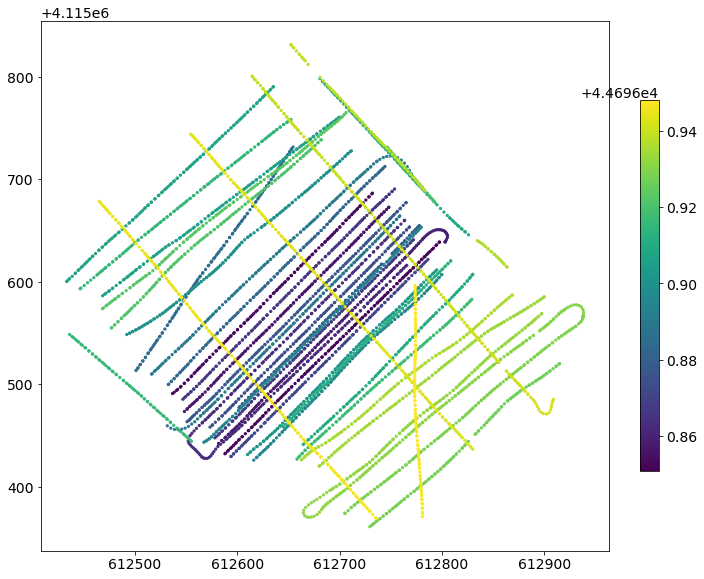

In [61]:
fig  = plt.figure(figsize=(10, 10))
# plt.plot(topography[:,0], topography[:,1], '.', ms=1)
out = plt.scatter(topography[:,0], topography[:,1], c=time_stamp, s=5)
plt.colorbar(out, fraction=0.03)
plt.gca().set_aspect(1)
plt.tight_layout()

## Step 2: Initiate `Stitched1DModel`

In [62]:
resistivity.shape

(5464, 20)

In [63]:
hz[:17].sum()

53.244

In [64]:
from SimPEG.electromagnetics.utils.em1d_utils import Stitched1DModel, plot_layer

In [65]:
n_layer = 17
model = Stitched1DModel(
    topography=topography,
    line=line,
    hz=hz[:n_layer],
    time_stamp=time_stamp, 
    physical_property=resistivity[:,:n_layer].flatten()
#     resistivity_vec
)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(


## Step3: Plot a vertical resistivity profile

In [66]:
from ipywidgets import widgets, interact

Text(0.5, 0, 'Resistivity ($\\Omega$m)')

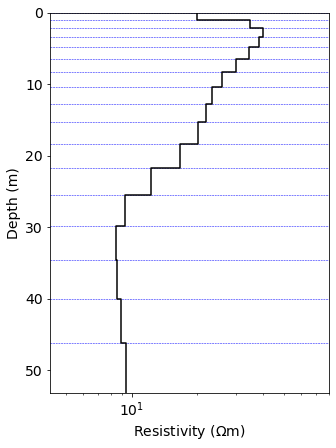

In [67]:
i_sounding = 1000
fig, ax = plt.subplots(1,1, figsize=(5, 7))
plot_layer(resistivity[i_sounding,:n_layer], model.mesh_1d, ax=ax, showlayers=True)
ylim = ax.get_ylim()
ax.set_ylim(ylim[1], ylim[0])
ax.set_xlabel("Resistivity ($\Omega$m)")

In [68]:
# TODO: Add this functionality into Stitched1DModel
def interact_plot_layer(i_sounding):
    fig, ax = plt.subplots(1,1, figsize=(5, 7))
    plot_layer(resistivity[i_sounding,:n_layer], model.mesh_1d, ax=ax, showlayers=True)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[1], ylim[0])
    ax.set_xlabel("Resistivity ($\Omega$m)")
    ax.set_title("Line number: {:.0f}\n Sounding number: {:.0f}".format(line[i_sounding], i_sounding), fontsize=14)
interact(
    interact_plot_layer, 
    i_sounding=widgets.IntSlider(min=0, max=df.shape[0]-1, step=1, value=0), 
    continuous_update=False
)

interactive(children=(IntSlider(value=0, description='i_sounding', max=5463), Output()), _dom_classes=('widget…

<function __main__.interact_plot_layer(i_sounding)>

## Step 4: Plot a vertical section

In [69]:
# Find unique line numbers
unique_line = np.unique(line)

Text(0.5, 1.0, 'Line number: 140')

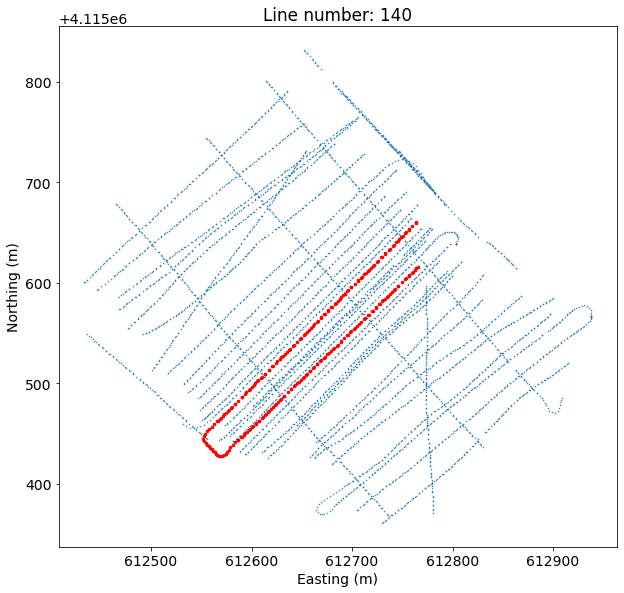

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
i_line = 4
ind_line = line == unique_line[i_line]
ax.plot(topography[:,0], topography[:,1], '.', ms=1)
ax.plot(topography[ind_line,0], topography[ind_line,1], '.', ms=5, color='r')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Line number: {:.0f}".format(unique_line[i_line]))

In [71]:
def foo(i_line):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ind_line = line == unique_line[i_line]
    ax.plot(topography[:,0], topography[:,1], '.', ms=1)
    ax.plot(topography[ind_line,0], topography[ind_line,1], '.', ms=5, color='r')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Line number: {:.0f}".format(unique_line[i_line]))
interact(foo, i_line=widgets.IntSlider(min=0, max=43-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i_line', max=42), Output()), _dom_classes=('widget-inter…

<function __main__.foo(i_line)>

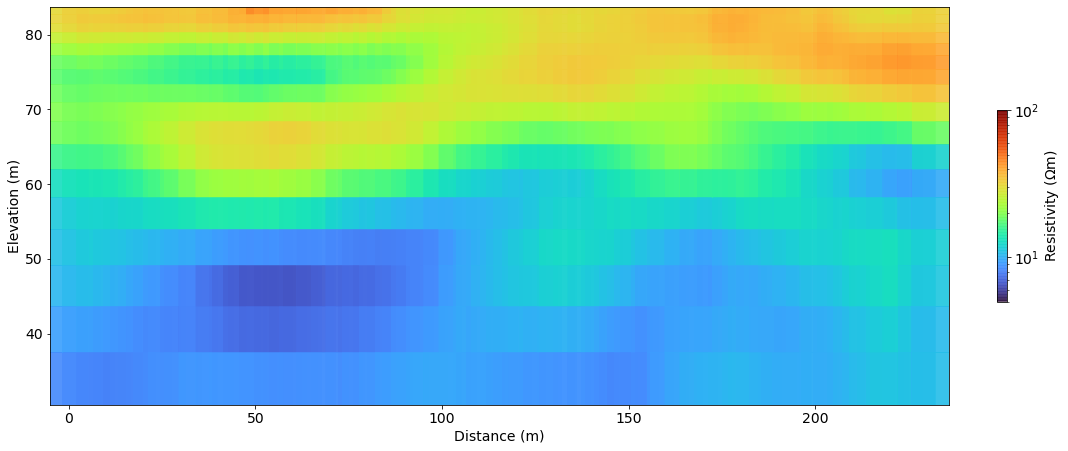

In [72]:
i_line = 23
quad, ax, cb = model.plot_section(i_line=i_line, x_axis='distance', aspect=2, cmap='turbo', clim=(5, 100), dx=5)
cb.set_label("Resistivity ($\Omega$m)")
# ax.set_xlim(0, 200)

## Step 5: Plot resistivity values of a each layer as points

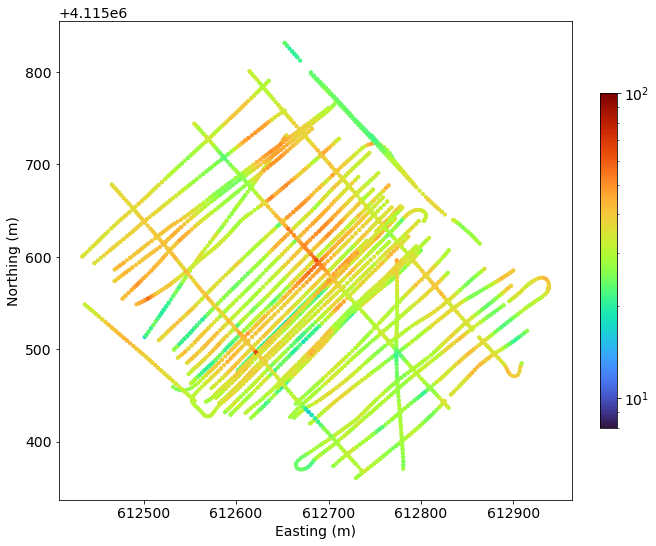

In [73]:
from matplotlib.colors import LogNorm
fig  = plt.figure(figsize=(10, 10))
i_layer = 0
out = plt.scatter(
    topography[:,0], topography[:,1], c=resistivity[:,i_layer], 
    s=10, 
    norm=LogNorm(vmin=8, vmax=100), 
    cmap='turbo'
)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(out, fraction=0.03)
plt.gca().set_aspect(1)

In [74]:
def foo(i_layer):
    fig  = plt.figure(figsize=(10, 10))
    out = plt.scatter(
        topography[:,0], topography[:,1], c=resistivity[:,i_layer], 
        s=10, 
        norm=LogNorm(vmin=8, vmax=100), 
        cmap='turbo'
    )
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.colorbar(out, fraction=0.03)
    plt.gca().set_aspect(1)
    plt.title("{:.0f}-th layer".format(i_layer+1))
interact(foo, i_layer=widgets.IntSlider(min=0, max=39, step=1, value=0))    

interactive(children=(IntSlider(value=0, description='i_layer', max=39), Output()), _dom_classes=('widget-inte…

<function __main__.foo(i_layer)>

## Step 6: Plot resistivity values as a 2D map

In [75]:
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
def inverse_distance_interpolation(
    xy, values, 
    dx=100, dy=100, x_pad=1000, y_pad=1000,
    power=0, epsilon=None, k_nearest_points=20, 
    max_distance=4000.,
):
    """
        Evaluating 2D inverse distance weighting interpolation
        for given (x, y) points and values.
        
        Inverse distance weight, w, can be written as:
            w = 1/(distance+epsilon)**power
        
        Parameters
        ----------
        xy : array_like
            Input array including (x, y) locations; (n_locations, 2)
        values: array_like
            Input array including values defined at (x, y) locations; (n_locations, )
        dx : int 
            Size of the uniform grid in x-direction
        dy : int 
            Size of the uniform grid in y-direction
        x_pad : float 
            Length of padding in x-direction
        y_pad : float 
            Length of padding in y-direction
        power: float
            Exponent used when evaluating inverse distance weight. 
        epsilon: float
            A floor value used when evaluating inverse distance weight. 
        k_nearest_points: int 
            k-nearest-point used when evaluating inverse distance weight.  
        max_distance: float
            A separation distance used to maks grid points away from the (x, y) locations.
        
        Returns        
        -------
        

    """
    xmin, xmax = xy[:,0].min()-x_pad, xy[:,0].max()+x_pad
    ymin, ymax = xy[:,1].min()-y_pad, xy[:,1].max()+y_pad

    nx = int((xmax-xmin) / dx)
    ny = int((ymax-ymin) / dy)
    hx = np.ones(nx) * dx
    hy = np.ones(ny) * dy
    x = np.arange(nx)*dx + xmin
    y = np.arange(ny)*dy + ymin
    X, Y = np.meshgrid(x, y)

    tree = KDTree(xy)

    d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k=int(k_nearest_points))
    if epsilon is None:
        epsilon = np.min([dx, dy])
    w = 1.0 / ((d+epsilon) ** power)
    values_idw = (np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1))
    mask_inds = ~distance_mask(
        (xy[:,0], xy[:,1]), maxdist=max_distance, coordinates=(X.flatten(), Y.flatten())
    )
    values_idw[mask_inds] = np.nan
    values_idw = values_idw.reshape(X.shape)
    return x, y, values_idw

<ipython-input-76-f2ab474df3e3>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  out = plt.pcolormesh(x, y, values_idw, norm=LogNorm(vmin=8, vmax=100),


Text(0.5, 1.0, 'Depth at 0.0 m')

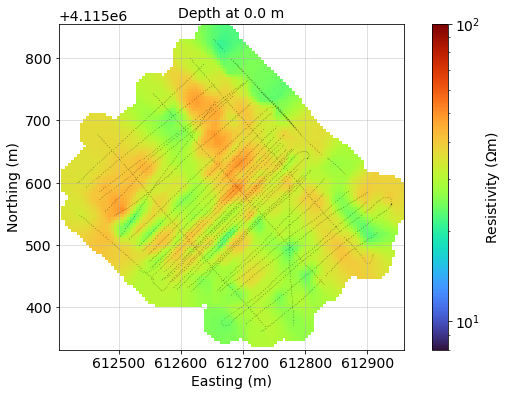

In [76]:
i_layer = 0
x, y, values_idw = inverse_distance_interpolation(
    topography[:,:2], resistivity[:,i_layer], 
    dx=5, dy=5, x_pad=30, y_pad=30,
    max_distance=30., k_nearest_points=30, power=2
)

fig, ax = plt.subplots(1,1, figsize=(10, 6))
depth = np.cumsum(np.r_[0., hz])
out = plt.pcolormesh(x, y, values_idw, norm=LogNorm(vmin=8, vmax=100), 
    cmap='turbo'
)
ax.plot(topography[:,0], topography[:,1], 'k.', ms=0.1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
cb = plt.colorbar(out)
cb.set_label('Resistivity ($\Omega$m)')
ax.grid(True, alpha=0.5)
ax.set_aspect(1)
ax.set_title("Depth at {:.1f} m".format(depth[i_layer]), fontsize=14)

## Step 7: Plot the resistivity model in 3D
- Export to files to be visualized in Leapfrog

In [77]:
from SimPEG import utils
def write_aem_leapfrog_csv(
    hz, Line, topography, properties,
    name_properties=['resistivity'],
    nskip=1, work_dir='./', fname_header=''
):

    n_sounding_all = topography.shape[0]
    stitched_model = Stitched1DModel(
        hz=hz,
        line=Line[::nskip],
        topography=topography[::nskip,:].copy()
    )
    depth_from = np.zeros((hz.size, stitched_model.n_sounding), order='F')
    depth_to = np.zeros((hz.size, stitched_model.n_sounding), order='F')

    # collar information
    lineid_collar = Line[::nskip]
    wellid_collar = np.arange(lineid_collar.size) + 1

    north_collar = stitched_model.topography[:,1]
    east_collar = stitched_model.topography[:,0]
    depth_max_collar = np.ones_like(wellid_collar) * hz.sum()
    elevation_collar = stitched_model.topography[:,2]

    # interval information

    for ii in range(stitched_model.n_sounding):
        depth_from[:,ii] = stitched_model.mesh_1d.vectorNx[:-1]
        depth_to[:,ii] = stitched_model.mesh_1d.vectorNx[1:]

    lineid = stitched_model.line.repeat(hz.size)
    wellid = wellid_collar.repeat(hz.size)
    east = utils.mkvc(stitched_model.xyz[:,0])
    north = utils.mkvc(stitched_model.xyz[:,1])
    depth_from = utils.mkvc(depth_from[:,:])
    depth_to = utils.mkvc(depth_to[:,:])

    df_collar = pd.DataFrame(data=np.c_[wellid_collar, stitched_model.line, east_collar, north_collar, elevation_collar, depth_max_collar], columns=['wellid', 'Line', 'X', 'Y', 'elevation', 'depth'])
    df_collar.to_csv(work_dir+'collar-{:s}.csv'.format(fname_header), index=False)


    distance_collar = np.zeros_like(wellid_collar)
    azimuth_collar = np.zeros_like(wellid_collar)
    dip_collar = np.ones_like(wellid_collar) * 90.

    df_survey = pd.DataFrame(data=np.c_[wellid_collar, distance_collar, azimuth_collar, dip_collar], columns=['wellid', 'distance', 'azimuth', 'dip'])
    df_survey.to_csv(work_dir+'survey-{:s}.csv'.format(fname_header), index=False)
    data = np.c_[wellid, depth_from, depth_to]
    for ii in range (len(name_properties)):
        data = np.c_[data, properties[:,ii].reshape((n_sounding_all, hz.size))[::nskip, :].flatten()]
    df_interval = pd.DataFrame(
        data=data,
        columns=['wellid', 'from', 'to'] + name_properties
    )
    df_interval.to_csv(work_dir+'interval-{:s}.csv'.format(fname_header), index=False)
    return df_collar, df_survey, df_interval

In [78]:
df_collar, df_survey, df_interval = write_aem_leapfrog_csv(
    hz, line, topography, np.c_[resistivity.flatten().reshape([-1,1]), np.log10(resistivity.flatten().reshape([-1,1]))],
    name_properties=['resistivity', 'resistivity_log10'],
    nskip=1, work_dir='./', fname_header='coyote'
)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(


In [79]:
!ls

TDEM_HorizontalLoop_LayeredEarth.ipynb
collar-coyote.csv
interval-coyote.csv
survey-coyote.csv
ttem_forward_modelling.ipynb
ttem_forward_modelling_solution.ipynb
ttem_plot.ipynb


## Step 8: Plot the resistivity model in as a 3D grid
- Interpolate the resistivity model to a 3D grid
- Export to files to be visualized in Paraview

In [80]:
model.get_3d_mesh(dx=5, dy=5, dz=1)

TensorMesh: 498,200 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    100    612,433.50    612,933.50      5.00      5.00    1.00
   y     94  4,115,360.75  4,115,830.75      5.00      5.00    1.00
   z     53         30.70         83.70      1.00      1.00    1.00

In [81]:
model.get_interpolation_matrix(npts=27)

In [82]:
from verde import distance_mask
resistivity_3d = model.interpolate_from_1d_to_3d(resistivity[:,:n_layer].flatten())
mask = distance_mask(
    (topography[:,0], topography[:,1]), 
    maxdist=20, 
    coordinates=(model.mesh_3d.gridCC[:,0], model.mesh_3d.gridCC[:,1])
)
resistivity_3d = resistivity_3d.flatten(order='F')
resistivity_3d[~mask] = np.nan

In [83]:
log_resistivity_3d = np.log10(resistivity_3d)

In [84]:
log_resistivity_3d[np.isnan(resistivity_3d)] = -1

In [85]:
model.mesh_3d.write_UBC("mesh.msh")

In [ ]:
model.mesh_3d.write_model_UBC("model.mod", log_resistivity_3d)

In [ ]:
model.mesh_3d.write_vtk("model.vtr", models={'resistivity':resistivity_3d})

In [ ]:
10**(np.arange(6) * 0.2 + 0.8)

In [ ]:
np.arange(6) * 0.2 + 0.8

# Questions?